Plots win rate vs. varying adversary/victim visits.

In [2]:
%load_ext autoreload
%autoreload 2
import re

import matplotlib
import matplotlib.axes
import matplotlib.figure
import matplotlib.pyplot as plt
import matplotlib.ticker
import pandas as pd
from statsmodels.stats.proportion import proportion_confint

import utils

# To save space in the body of our paper, we're shrinking
# the height of the plots in this notebook.
FIG_HEIGHT_MULTIPLIER = 0.7

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("default"),
        utils.get_style("2-col"),
        {"ytick.left": True, "ytick.right": True},
    ]
)


def force_minor_ticks(ax: matplotlib.axes.Axes) -> None:
    """Force minor ticks to show on a plot."""
    # https://stackoverflow.com/a/73094650/1337463
    ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=999, subs="auto"))

In [3]:
def filter_df_for_player(df: pd.DataFrame, player_substring: str):
    """Get df rows matching a player substring."""
    return df[(df['b_name'].str.contains(player_substring)) | (df['w_name'].str.contains(player_substring))]

def get_adv_win_grouped_by_victim_visits(
    df: pd.DataFrame,
    # default query returns everything
    df_query: str = 'index == index or index != index',
    alpha: float = 0.05,
) -> tuple[pd.Series, pd.Series, pd.Series]:
    """
    Get the adversary win rate grouped by victim visits.

    Returns: (mean, lower bound, upper bound)
    """
    gb = df.query(df_query).groupby("victim_visits")

    adv_win_proportion = gb.adv_win.mean()
    adv_win_lo, adv_win_hi = proportion_confint(
        gb.adv_win.sum(), gb.adv_win.count(), alpha=alpha, method="beta"
    )

    return 100 * adv_win_proportion, 100 * adv_win_lo, 100 * adv_win_hi

def plot_victim_visit_sweep(
    dfs: list[tuple[pd.DataFrame, str]],
    victim_label: str,
    custom_ylabel: str | None = None,
) -> tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]:
    """Plot performance of A-MCTS-{R,S++} vs. varying victim visits.

    Args:
        dfs: Dataframes of games paired with a label for each dataframe.
        victim_label: The label to give the victim on the plot.
    """
    fig, ax = plt.subplots(1, 1)

    for df, label in dfs:
        m, l, h = get_adv_win_grouped_by_victim_visits(df)
        m.plot(label=label)
        ax.fill_between(m.index, l, h, alpha=0.3)

    plt.ylim(-5, 105)
    plt.xscale("log")
    plt.ylabel(
        custom_ylabel or f"Win \\% vs. {victim_label}"
    )
    plt.xlabel("Victim visits")
    force_minor_ticks(ax)
    utils.filter_x_minor_ticks()
    if len(dfs) > 1:
        plt.legend()

    return fig, ax

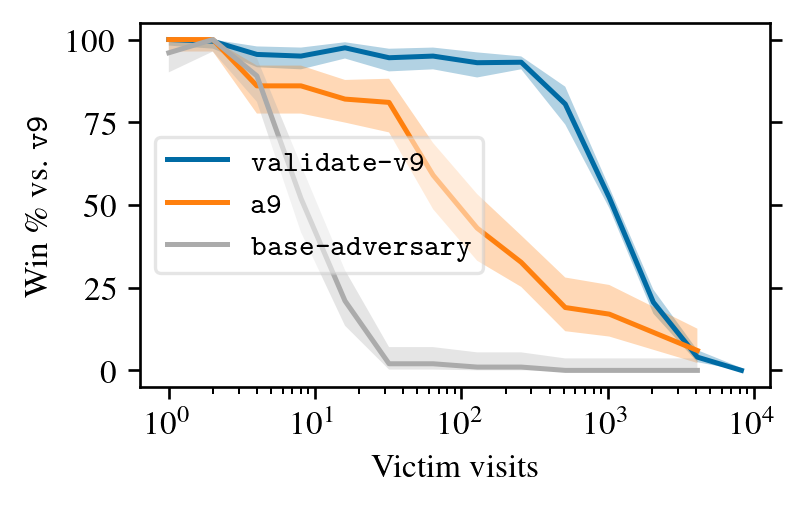

In [4]:
attack_h9_df = utils.parse_sgfs(["/shared/match/ttseng-attack-h9-240314/vs-h9"])
utils.parse_for_match(attack_h9_df, adv_name_regex="attack-h9")

r9_df = utils.parse_sgfs(["/shared/match/ttseng-rs-vs-hs-240119/job-19"])
# Only get games against h9
r9_df = filter_df_for_player(r9_df, "h9")
utils.parse_for_match(r9_df, adv_name_regex="r9")

original_cyclic_df = utils.parse_sgfs(["/shared/match/ttseng-rs-vs-hs-240119/job-1"])
# Only get games against h9
original_cyclic_df = filter_df_for_player(original_cyclic_df, "h9")
utils.parse_for_match(original_cyclic_df, adv_name_regex="r0-v600")

fig, ax = plot_victim_visit_sweep(
    [
        (attack_h9_df, r"\texttt{validate-v9}"),
        (r9_df, r"\texttt{a9}"),
        (original_cyclic_df, r"\texttt{base-adversary}"),
    ], 
    r"\texttt{v9}")
# shrink, move, and make transparent the legend. otherwise plot lines not as visible
legend = ax.legend(prop={"size": 9}, loc="center left")
legend.get_frame().set_alpha(0.5)
fig.savefig("vs-h9-visits.pgf", backend="pgf")

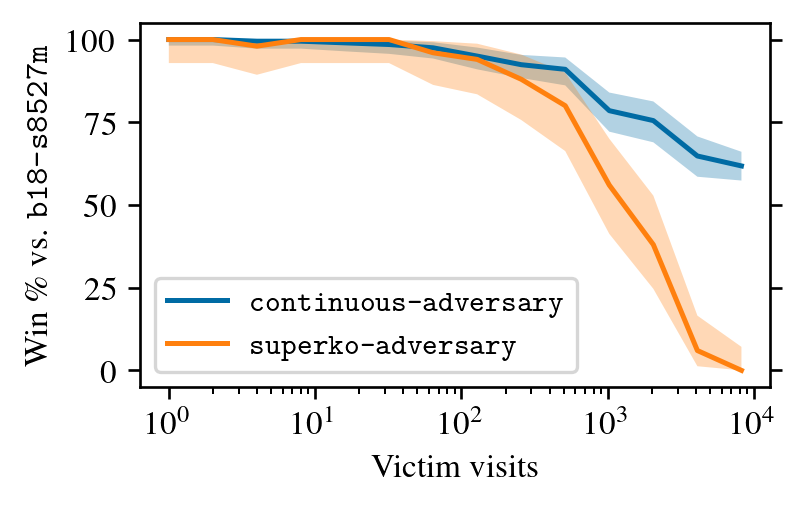

In [5]:
cont_df = utils.parse_sgfs(
    [
        "/shared/match/ttseng-cont-vs-b18-s8527m-240311/s630m-upto-v4096",
        "/shared/match/ttseng-cont-vs-b18-s8527m-240311/s630m-v8192-and-b60",
    ]
)
cont_df = filter_df_for_player(cont_df, "b18")
utils.parse_for_match(cont_df, adv_name_regex="cont")

# TODO this data needs to be updated after running evals
ko_df = utils.parse_sgfs(["/shared/match/ttseng-attack-b18-prelim-240329/victim-visits"])
utils.parse_for_match(ko_df, adv_name_regex="attack-b18")

fig, ax = plot_victim_visit_sweep(
    [
        (cont_df, r"\texttt{continuous-adversary}"),
        (ko_df, r"\texttt{superko-adversary}"),
    ],
    r"\texttt{b18-s8527m}",
)
# shrink legend to keep plot lines visible
ax.legend(prop={"size": 9})
fig.savefig("vs-b18-visits.pgf", backend="pgf")

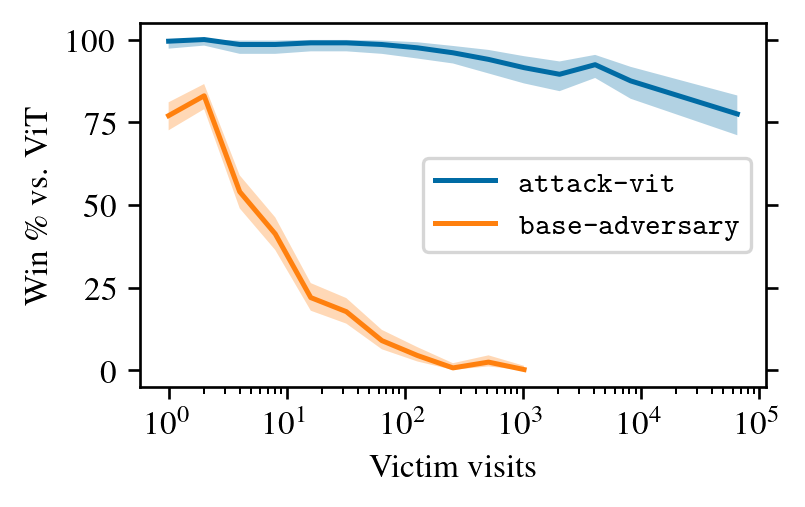

In [59]:
attack_vit_df = utils.parse_sgfs(["/shared/match/ttseng-attack-vit-240311/v1-to-v8192-and-v65536"])
utils.parse_for_match(attack_vit_df, adv_name_regex="attack-vit")

original_cyclic_df = utils.parse_sgfs(["/shared/match/ttseng-vitb16-vs-cyclic"])
utils.parse_for_match(original_cyclic_df, adv_name_regex="cyclic")

fig, ax = plot_victim_visit_sweep(
    [
        (attack_vit_df, r"\texttt{attack-vit}"),
        (original_cyclic_df, r"\texttt{base-adversary}"),
    ],
    r"ViT",
)
# shrink legend to keep plot lines visible
ax.legend(prop={"size": 9})
fig.savefig("vs-vit-visits.pgf", backend="pgf")

attack_vit_xlim = ax.get_xlim()

/KataGoVisualizer/notebooks/notebooks/paper/utils.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.adv_win = df.adv_color == df.win_color
/KataGoVisualizer/notebooks/notebooks/paper/utils.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.victim_visits = df.victim_name.str.extract(r"-v(\d+)").astype(int)
/KataGoVisualizer/notebooks/notebooks/paper/utils.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

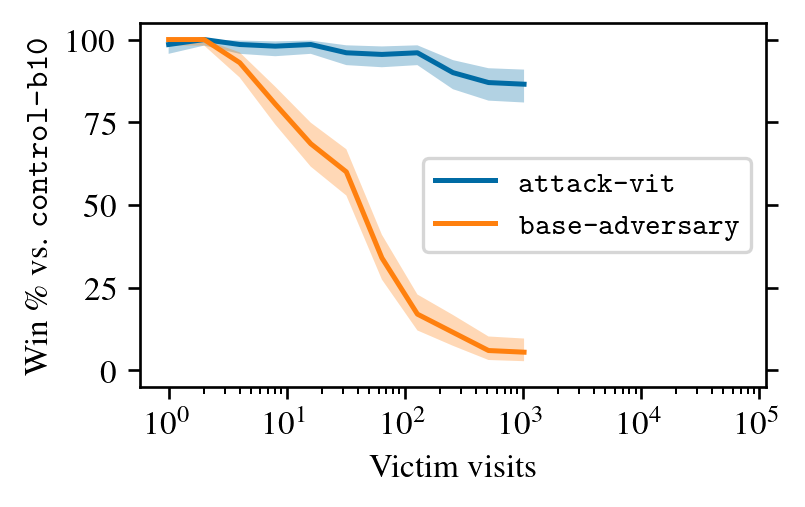

In [60]:
df = utils.parse_sgfs(["/shared/match/attack-b10-240311"])
attack_vit_df = filter_df_for_player(df, "attack-vit")
utils.parse_for_match(attack_vit_df, adv_name_regex="attack-vit")
original_cyclic_df = filter_df_for_player(df, "cyclic")
utils.parse_for_match(original_cyclic_df, adv_name_regex="cyclic")

fig, ax = plot_victim_visit_sweep(
    [
        (attack_vit_df, r"\texttt{attack-vit}"),
        (original_cyclic_df, r"\texttt{base-adversary}"),
    ],
    r"\texttt{control-b10}",
)
# shrink legend to keep plot lines visible
ax.legend(prop={"size": 9})
# keep x-axis the same as ViT plot for easier visual comparison
ax.set_xlim(*attack_vit_xlim)
fig.savefig("vs-b10-visits.pgf", backend="pgf")